In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

from mlforecast import MLForecast
from mlforecast.target_transforms import Differences

import lightgbm as lgb
import xgboost  as xgb

from sklearn.linear_model import LinearRegression
from sklearn.ensemble     import RandomForestRegressor

In [4]:
# Set parameters for generating data
a = 0.4
b = 1
c = 1
w = 10

# Set start date for the timestamps
start_date = '2020-01-01'

# Set the number of rows in the DataFrame
num_rows = 365  # Assuming one year of data

# Generate the timestamps
timestamps = pd.date_range(start=start_date, periods=num_rows, freq='D')

# Generate the values for the column ds
x = np.linspace(0, 10, num_rows)
y = a*x*np.sin(w*x) + b*x + c

# Create the DataFrame
df = pd.DataFrame({'y': y, 'ds': timestamps})
df["unique_id"] = "test"

# Print the DataFrame
# df.plot(x='ds', y='y', figsize=(12, 6), title='Synthetic Data', grid=True)
# plt.show()

In [9]:
models = [
    LinearRegression(),
    lgb.LGBMRegressor(),
    RandomForestRegressor(random_state=0),
    xgb.XGBRegressor()
]

mlf = MLForecast(
    models = models,
    lags=[1,2,10],
    freq = 'D',
    target_transforms=[Differences([1])], #according to the frequency in sin(w*x)
)
        
mlf.fit(df)

y_pred = mlf.predict(100)

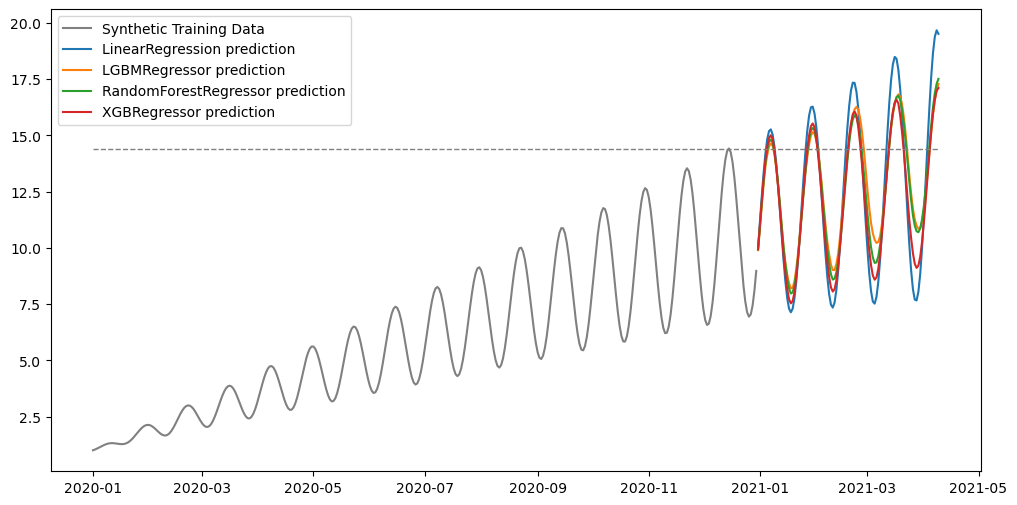

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(df['ds'], df['y'], color='grey', label="Synthetic Training Data")

for name in y_pred.columns[2:]:
    plt.plot(y_pred.ds.values, y_pred[name],label=f"{name} prediction")

plt.hlines(np.max(df.y), df['ds'].min(), y_pred['ds'].max(), color='grey', linestyle='--', linewidth=1)
plt.legend()
plt.show()

Learnings:  
- Treebased models can return forcast outside of the training data range when feature engineering is added. Without feature engineering, they can't. 
- Treebased models are terrible without proper feature engineering.   
        - The difference makes it such the right trend is found. It does not really matter which differencing is used.  
        - I haven't found a way to make it figure out the increase in amplitude. --> Maybe log, or BoxCox, or something else.
        
- The lags define the structure of the model and have to be chosen carefully. They are probably the most important hyperparameter.
- LinearRegression looks much better in this case. 

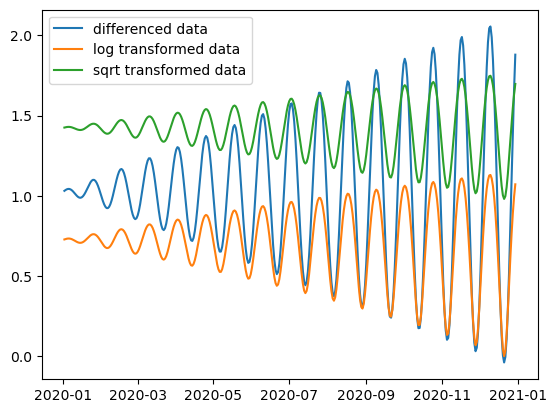

In [103]:
from scipy import stats

# Add a constant value to shift the data
shifted_data = y - np.min(y) + 1

transformed_data = np.log(shifted_data)

plt.plot(df.ds[1:],y+1, label="differenced data")
plt.plot(df.ds[1:],transformed_data , label="log transformed data")
plt.plot(df.ds[1:],np.sqrt(y+2) , label="sqrt transformed data")
plt.legend()